## 初始化与计算

In [1]:
import os,sys
import numpy as np
import os,sys
import numpy as np

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import os
from scipy.optimize import curve_fit
import inspect

def read_sys_json(path):
    """
    从指定路径读取系统参数 JSON 文件
    参数:
    path (str): 包含 JSON 文件的目录路径。
    返回:
    dict: 包含系统参数数据的 dict
    """
    import json
    file_path = path
    try:
        # 以只读模式打开 JSON 文件
        with open(file_path, 'r', encoding='utf-8') as file:
            # 读取 JSON 文件内容并转换为字典
            data_dict = json.load(file)
            for key,value in data_dict.items():
                if type(value)==float:
                    print(key,': {:,}'.format(value))
                else:
                    print(key,':',value)
        return data_dict
    except FileNotFoundError:
        print(f"未找到文件: {file_path}")
    except json.JSONDecodeError:
        print(f"文件 {file_path} 不是有效的 JSON 格式。")

def read_id900_binary(path,channel):
    """
    从指定路径读取特定通道的二进制文件，并将其转换为 Pandas DataFrame。

    参数:
    path (str): 包含二进制文件的目录路径。
    channel (int): 要读取的通道号。

    返回:
    pandas.DataFrame: 包含二进制文件数据的 DataFrame,列名为 'time_satmp' 和 'start_index'。
    None: 如果未找到指定通道的二进制文件。
    """
    
    for file_name in os.listdir(path):
        if 'C{}'.format(channel) in file_name:
            pmt_array=np.fromfile('{}/{}'.format(path,file_name),dtype=np.uint64).reshape(-1,2)
            pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
            return pmt_pd
    print('No channel {} bin file found'.format(channel))
    return None

def read_id900_binary_from_file(file_path,start_index=True):
    """
    从指定路径读取特定通道的二进制文件，并将其转换为 Pandas DataFrame。

    参数:
    path (str): 包含二进制文件的目录路径。

    返回:
    pandas.DataFrame: 包含二进制文件数据的 DataFrame,列名为 'time_satmp' 和 'start_index'。
    None: 如果未找到指定通道的二进制文件。
    """
    if start_index:
        pmt_array=np.fromfile(file_path,dtype=np.uint64).reshape(-1,2)
        pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
        return pmt_pd
    else:
        pmt_array=np.fromfile(file_path,dtype=np.uint64)
        pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp'])
        pmt_pd=pmt_pd.astype(np.int64)
        pmt_pd['start_index']=np.sign(pmt_pd.diff())
        pmt_pd.loc[0,'start_index']=-1
        pmt_pd.loc[pmt_pd['start_index']==1,'start_index']=0  
        pmt_pd.loc[pmt_pd['start_index']==-1,'start_index']=1
        pmt_pd['start_index']=pmt_pd['start_index'].cumsum()
        return pmt_pd


def window_index(df, start, end, pulse_num=1, pulse_interval=5e6):
    """
    生成一个布尔索引，用于筛选出指定数据框中时间戳在一系列时间窗口内的行。

    参数:
    df (pandas.DataFrame): 输入的数据框，包含 'time_satmp' 和 'start_index' 列。
    start (int or float): 第一个时间窗口的起始时间。
    end (int or float): 第一个时间窗口的结束时间。
    pulse_num (int, 可选): 脉冲的数量，默认为 1。
    pulse_interval (float, 可选): 相邻时间窗口之间的间隔[ps]，默认为 5us。

    返回:
    pandas.Series: 一个布尔索引，用于筛选出符合条件的行。
    """
    # 初始化一个布尔索引，所有元素初始化为 False
    _index = df['start_index'] < 0
    # 循环生成多个时间窗口的布尔索引
    for pulse_i in range(pulse_num):
        # 计算当前时间窗口的起始和结束时间
        _window_start = start + pulse_i * pulse_interval
        _window_end = end + pulse_i * pulse_interval
        # 生成当前时间窗口的布尔索引，并累加到总索引上
        _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)
    return _index


def count2gamma(df):
    """
    该函数用于将 PMT 计数数据转换为 gamma 值、gamma 误差和相位值。

    参数:
    df (pandas.DataFrame): 包含 PMT 计数数据的 DataFrame，应包含 'pmt1'、'pmt2' 和 'turn' 列。

    返回:
    pandas.DataFrame: 包含计算后的 'gamma'、'gamma_err' 和 'phase' 列的 DataFrame。
    """
    # 计算 gamma 值，公式为 (pmt1 - pmt2) / (pmt1 + pmt2)
    df['gamma']=(df['pmt1']-df['pmt2'])/(df['pmt1']+df['pmt2'])
    # 计算 gamma 误差的平方，公式为 (2 * pmt2 / ((pmt1 + pmt2) ** 2) * sqrt(pmt1)) ** 2 + (-2 * pmt1 / ((pmt1 + pmt2) ** 2) * sqrt(pmt2)) ** 2
    df['gamma_err']=(2*df['pmt2']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt1']))**2+(-2*df['pmt1']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt2']))**2
    # 对 gamma 误差的平方取平方根，得到 gamma 误差
    df['gamma_err']=np.sqrt(df['gamma_err'])
    # 计算相位值，公式为 turn * 360 * 2
    df['phase']=df['turn']*360*2



# 定义模型函数：正弦波
def model_func_count_offset(x, gamma, phase_offset,count_offset):
    """
    A sin(x + phi) + B
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))+count_offset

def model_func_sin(x, gamma, phase_offset):
    """
    A sin(x + phi)
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))


# 生成数据点
def estimate_gamma(df,model_func=model_func_count_offset):
    """  A cos(df + B)
    return estimate [A,B]"""
    x_data = df['turn']*360*2  # x轴数据
    y_data = df['gamma']  # y轴数据
    y_err = df['gamma_err']  # y轴数据误差
    pmt1 = df['pmt1']
    pmt2 = df['pmt2']
    x_data_arange = np.linspace(0, 360*2, 200)  # 生成更多数据点用于拟合
    # 使用curve_fit进行非线性最小二乘法拟合
    # 定义参数的下界和上界
    # 获取函数的参数信息
    sig = inspect.signature(model_func)
    # 获取参数的数量
    param_count = len(sig.parameters)
    if param_count == 2+1:
        lower_bounds = [0, 0]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    elif param_count == 3+1:
        lower_bounds = [0, 0,-0.1]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi,0.2]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    else:
        print('model_func has {} parameters, but only 2 or 3 parameters are supported'.format(param_count))
        params, covariance = curve_fit(model_func, x_data, y_data,sigma=y_err)

    # 使用拟合参数计算预测值
    y_pred = model_func(x_data, *params)

    # 计算R²
    mean_y = np.mean(y_data)
    total_variance = np.sum((y_data - mean_y) ** 2)
    residual_variance = np.sum((y_data - y_pred) ** 2)
    r_squared = 1 - (residual_variance / total_variance)
    # 输出拟合参数
    if param_count == 2+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, R²={r_squared:.3%}")
    elif param_count == 3+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, count_offset={params[2]:.3f}±{np.sqrt(np.diag(covariance))[2]:.3f}, R²={r_squared:.3%}")

    # 绘制原始数据点和拟合曲线
    plt.subplot(211)
    plt.errorbar(x_data,pmt1,fmt='-o',yerr=np.sqrt(pmt1),label='pmt1',capsize=5)
    plt.errorbar(x_data,pmt2,fmt='-o',yerr=np.sqrt(pmt2),label='pmt2',capsize=5)
    plt.plot(x_data,(pmt1+pmt2)/2, 'x-.', label='(pmt1+pmt2)/2')
    plt.xlim(0,360*2)
    plt.xlabel('phase offset with 729 OAM turn [°]')
    plt.ylabel('pmt counts')
    plt.title('PMT count, experimental error estimate by shot noise')
    plt.legend(loc=1)
    plt.grid()
    plt.subplot(212)
    plt.errorbar(x_data, (y_data), fmt='o', label='experimental data',yerr=y_err,capsize=5)
    plt.plot(x_data_arange,(model_func(x_data_arange, *params)), '-', label='fit {:.1%}±{:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0]))
    plt.xlabel('phase offset with 729 OAM turn [°] {:+.2f}°'.format(params[1]/np.pi*180))
    plt.ylabel('estimae gamma')
    plt.title('LS estimae $\\gamma$: {:.3%}±{:.3%}, $R^2=${:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0],r_squared))
    plt.xlim(0,360*2)
    plt.legend(loc=1)
    plt.grid()
    plt.tight_layout()
    params_err=np.sqrt(np.diag(covariance))

    return params,params_err

1. 创建对应turn的文件夹，将变量名`turn`改为对应值  
    1. 将ID1000文件夹下C3、C4的bin文件复制到turn文件夹下  
        C3、C4的bin文件夹名与ARTIQ中`experiment label`一致.  
        例如turn_0.635_C3_xxx.bin、turn_0.635_C4_xxx.bin,其中xxx为采数启动时间  
    2. 将alice、bob的谈探测文件复制到turn文件夹下，文件名分别更正为Alice.txt、Bob.txt  
    
2. 修改`period`为对应周期，单位为[s]  

3. 修改`window_start`、`window_end`为荧光计数窗口，一般与ID1000的窗口保持一致，单位为[ps]

4. 修改`time_start`、`time_stop`为分析数据截至时间，单位为[s]

In [2]:
fold=os.listdir()
turns=[]
for i,_ in enumerate(fold):
    try:
        "{}".format(float(_.split('_')[0]))
        turns.append(_)
    except:
        pass
    print(i,_)
print(str(turns).replace('\'','"'))

0 sys.json
1 0.5
2 gamma.ipynb
3 0.4
4 0.3
5 gamma_res_time.csv
6 0.125
7 0.2
8 fig_sm_5b.jpeg
9 fig_sm_5b.ipynb
10 0.1
11 gamma_fit.jpeg
12 0.375
["0.5", "0.4", "0.3", "0.125", "0.2", "0.1", "0.375"]


### 计算光子数

In [3]:
sys_json = read_sys_json('sys.json')

# 荧光计数窗口
window_start = sys_json['window_start(ps)']
window_end = sys_json['window_end(ps)']
# 分析数据截至时间
period = sys_json['period(s)']
time_start = sys_json['time_start(s)']
time_stop = sys_json['time_stop(s)']
# 脉冲
pulse_num = sys_json['pulse_num']
pulse_interval = sys_json['pulse_interval(ps)']
# 相位
turn = sys_json['turns'][-1]
# 外层计数验证
threshold = sys_json['threshold']
inner_loop = sys_json['inner_loop']
start_index = (sys_json['start_index']>0)


comment : This is a json file for TDC count.
blcok0 : count windows info
window_start(ps) : 480,000.0
window_end(ps) : 546,000.0
block1 : recquire time info
period(s) : 0.0005
time_start(s) : 0
time_stop(s) : 400000
block2 : pulse info
pulse_num : 1
pulse_interval(ps) : 65,000,000.0
block3 : turn / phase info
turns : ['0.125', '0.3', '0.375', '0.1', '0.2', '0.4', '0.5']
block4 : windwo move info
window_start_list(ns) : [620, 622, 624]
window_len(ns) : 4
block5 : monitor pulse info
monitor_start(ps) : 45441800
monitor_end(ps) : 45443000
block6 : outer count info
threshold : 1
inner_loop : 1000000
start_index : 1


In [4]:
for _ in os.listdir(turn):
    if _.endswith('.bin') and 'C3' in _:
        bin_path=os.path.join(turn,_)

In [5]:
# bin_path=r'SP_0_10km_Inter_0.371turns_C3_2025-09-07T22_50_48.bin'
pmt1_df=read_id900_binary_from_file(bin_path,start_index=start_index)
pmt2_df=read_id900_binary_from_file(bin_path.replace('C3','C4'),start_index=start_index)

## 添加反映数据是否因为离子雾化需要删除的序列
# pmt1_df['delete'] = np.logical_not(np.isin(pmt1_df['start_index'], drop_inner_index))
# pmt2_df['delete'] = np.logical_not(np.isin(pmt2_df['start_index'], drop_inner_index))
# ## 时间限制
# pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
# pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)].copy()
pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)].copy()
## 计算时间窗内光子数
pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM=pmt1_count.sum()
PMT2_SUM=pmt2_count.sum()
print('pmt1:{}, pmt2:{}'.format(PMT1_SUM,PMT2_SUM))
max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
print('cps1:{}, cps2:{}'.format(PMT1_SUM/max_time,PMT2_SUM/max_time))

pmt1:795, pmt2:941
cps1:7.9508745962055825, cps2:9.411035213873525


/tmp/ipykernel_218672/3980367741.py:110: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)


## 时域分布

 TDC histgram with pulse num:1, pulse interval:65.0us.


/tmp/ipykernel_218672/3980367741.py:110: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)


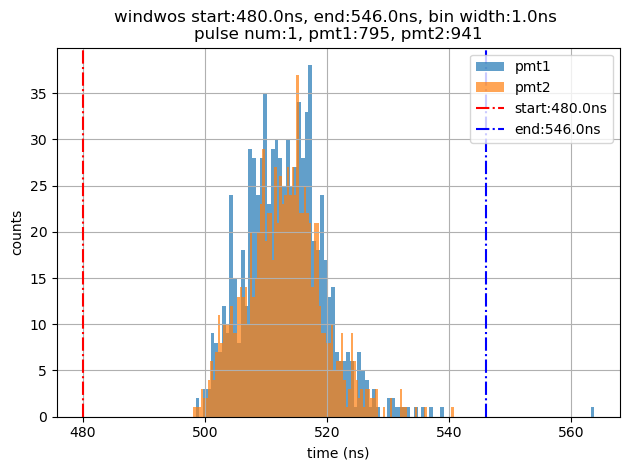

cumsum with pulse num:1.


In [6]:
### 光子时间分布 
def hist_count(pmt1_df,pmt2_df,bin_t):
    """
    计数窗口内的光子数量，并绘制直方图展示不同探测器的光子计数随时间的分布。

    参数:
    pmt1_df (pandas.DataFrame): 第一个探测器的数据框，包含 'time_satmp' 列。
    pmt2_df (pandas.DataFrame): 第二个探测器的数据框，包含 'time_satmp' 列。
    bin_t (int): 直方图的时间间隔，单位为皮秒 (ps)。

    返回:
    无
    """
    hist_time_wid=20e3 # unit ps
    # bin_t=1000 #ps
    pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
    pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
    info='windwos start:{:,.1f}ns, end:{:,.1f}ns, bin width:{:.1f}ns \n'.format(window_start/1e3,window_end/1e3, bin_t/1e3)
    info+='pulse num:{}, pmt1:{:,.0f}, pmt2:{:,.0f}'.format(pulse_num,PMT1_SUM,PMT2_SUM)
    bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # width of bin is 100ps 
    plt.hist(pmt1_hist_ts/1000,bins=bin_wid,label='pmt1',alpha=0.7)
    plt.hist(pmt2_hist_ts/1000,bins=bin_wid,label='pmt2',alpha=0.7)
    plt.xlabel('time (ns)')
    plt.ylabel('counts')
    plt.axvline(window_start/1000,color='r',linestyle='-.',label='start:{:.1f}ns'.format(window_start/1000))
    plt.axvline(window_end/1000,color='b',linestyle='-.',label='end:{:.1f}ns'.format(window_end/1000))
    plt.legend(loc=1)
    plt.title(info)
    plt.tight_layout()
    plt.grid()
print(' TDC histgram with pulse num:{}, pulse interval:{:.1f}us.'.format(pulse_num,pulse_interval/1e6))
hist_count(pmt1_df,pmt2_df,bin_t=1000)
# plt.yscale('log')
plt.savefig(bin_path.replace('.bin','_hist.jpeg'),dpi=300)
plt.show()
### PMT 计数时间累积
def plot_cumsum(pmt1_count,pmt2_count,period=500e-6):
    "画出累加计数和相位估计"
    max_time=max(pmt1_count.index.max(),pmt2_count.index.max())
    time_index=np.arange(0,max_time+1,1)
    pmt1=np.zeros_like(time_index)
    pmt2=np.zeros_like(time_index)
    pmt1[pmt1_count.index]=pmt1_count.values
    pmt2[pmt2_count.index]=pmt2_count.values
    pmt1=pmt1.cumsum()
    pmt2=pmt2.cumsum()
    es_phase=(pmt1-pmt2)/(pmt1+pmt2)
    es_phase[es_phase!=es_phase]=0
    fig=plt.figure(figsize=(8,6))
    plt.subplot(211)
    plt.plot(time_index*period,pmt1,label='pmt1')
    plt.plot(time_index*period,pmt2,label='pmt2')
    plt.plot(time_index*period,pmt1+pmt2,label='sum')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.legend(loc=2)
    plt.title('intergrate counts, pulse num:{:.0f}'.format(pulse_num))
    plt.xlabel('time (s)')
    plt.ylabel('counts')
    plt.grid()
    plt.subplot(212)
    plt.plot(time_index*period,es_phase,label='gamma')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.xlabel('time (s)')
    plt.ylabel(r'$\gamma \cos{\phi}$')
    plt.title('turn:{}, phase:{:.3f}°'.format(turn,float(turn.split('_')[0])*360*2))
    plt.grid()
    plt.tight_layout()
    return fig
print('cumsum with pulse num:{:.0f}.'.format(pulse_num))
# plot_cumsum(pmt1_count,pmt2_count,period=period)
# plt.savefig(bin_path.replace('.bin','_cumsum.jpeg'),dpi=300)
# plt.show()

## 单脉冲分析

   time[us]  pmt1  pmt2
0       0.0   371    17
all pmt1:371, pmt2:17


C:\Users\Public_B302_CC2\AppData\Local\Temp\ipykernel_22736\3980367741.py:110: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)


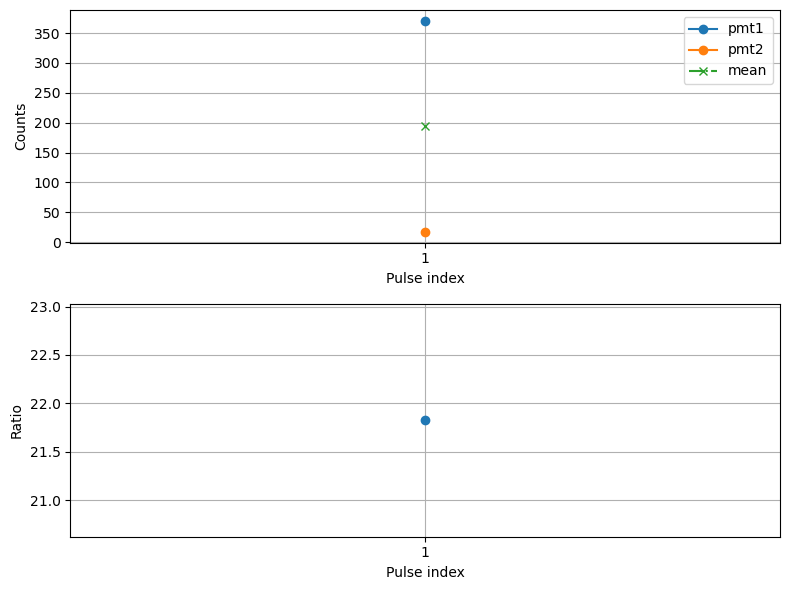

In [ ]:
def pulse_count_df(pmt1_df,pmt2_df,pulse_interval=13e6,pulse_num=10,pulse_offset=0):
    """
    计算两个数据框（pmt1_df 和 pmt2_df）在一系列脉冲时间窗口内的脉冲计数，并将结果存储在一个 DataFrame 中。

    参数:
    pmt1_df (pandas.DataFrame): 第一个数据框，包含脉冲时间戳和起始索引。
    pmt2_df (pandas.DataFrame): 第二个数据框，包含脉冲时间戳和起始索引。
    pulse_interval (float, 可选): 脉冲间隔时间，默认为 5e6 ps。
    pulse_num (int, 可选): 要处理的脉冲数量，默认为 10。
    pulse_offset (int, 可选): 脉冲计数的起始偏移量，默认为 0。

    返回:  
    pandas.DataFrame: 包含每个脉冲的时间和两个数据框的脉冲计数的 DataFrame。
    """
    pulse_dict={'time[us]':[],'pmt1':[],'pmt2':[]}
    for pulse_i in range(pulse_offset,pulse_num):
        pulse_start=window_start+pulse_i*pulse_interval
        pulse_end=window_end+pulse_i*pulse_interval
        pmt1_pulse_index=window_index(pmt1_df,pulse_start,pulse_end)
        pmt2_pulse_index=window_index(pmt2_df,pulse_start,pulse_end)
        pmt1_pulse_count=pmt1_df[pmt1_pulse_index]['start_index'].value_counts().sort_index(ascending=True)
        pmt2_pulse_count=pmt2_df[pmt2_pulse_index]['start_index'].value_counts().sort_index(ascending=True)

        pulse_dict['time[us]'].append(pulse_i*pulse_interval*1e-6)
        pulse_dict['pmt1'].append(sum(pmt1_pulse_count))
        pulse_dict['pmt2'].append(sum(pmt2_pulse_count))
    return pd.DataFrame(pulse_dict)

pulse_df=pulse_count_df(pmt1_df,pmt2_df,pulse_num=pulse_num,pulse_interval=pulse_interval)
print(pulse_df)
print('all pmt1:{:,.0f}, pmt2:{:,.0f}'.format(np.sum(pulse_df['pmt1']),np.sum(pulse_df['pmt2'])))



def plot_pulse_counts(pulse_df):
    """
    绘制脉冲计数的可视化图表。

    参数:  
    pulse_df (pandas.DataFrame): 包含脉冲计数数据的 DataFrame，至少包含 'pmt1' 和 'pmt2' 列。

    返回:  
    matplotlib.figure.Figure: 包含绘制图表的 Figure 对象。
    """
    fig = plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(1+pulse_df.index,pulse_df['pmt1'],'o-',label='pmt1')
    plt.plot(1+pulse_df.index,pulse_df['pmt2'],'o-',label='pmt2')
    plt.plot(1+pulse_df.index,(pulse_df['pmt1']+pulse_df['pmt2'])/2,'x-.',label='mean')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.subplot(2,1,2)
    if pulse_df['pmt1'].mean()>=pulse_df['pmt2'].mean():
        plt.plot(1+pulse_df.index,pulse_df['pmt1']/pulse_df['pmt2'],'o-')
    else:
        plt.plot(1+pulse_df.index,pulse_df['pmt2']/pulse_df['pmt1'],'o-')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Ratio')
    plt.grid()
    plt.tight_layout()
    return fig

plot_pulse_counts(pulse_df)
plt.savefig(bin_path.replace('.bin','_pulse_counts.jpeg'),dpi=300)
plt.show()

## 输出到文件

In [ ]:
out_csv='gamma_res_time.csv'
try:
    with open(out_csv, 'r') as f:
        pass
except FileNotFoundError:
    # 文件不存在，写入标题
    with open(out_csv, 'w') as f:
        f.write('turn,state,start(ps),end(ps),pmt1,pmt2,g,phase\n')

with open(out_csv,'a') as f:
    f.write('{a},origin,{t0:.0f},{t1:.0f},{pmt1:.0f},{pmt2:.0f},{g:.2%},{phase:.0f}\n'.format(a=turn.split('_')[0],t0=window_start,t1=window_end,pmt1=PMT1_SUM,pmt2=PMT2_SUM,g=(PMT1_SUM-PMT2_SUM)/(PMT1_SUM+PMT2_SUM),phase=float(turn.split('_')[0])*360*2))

# Estimate gamma

In [2]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']

-------------origin data-----------------
Fitted parameters: gamma=0.980±0.002, phase_offset=3.193±0.007, count_offset=-0.005±0.002, R²=99.967%


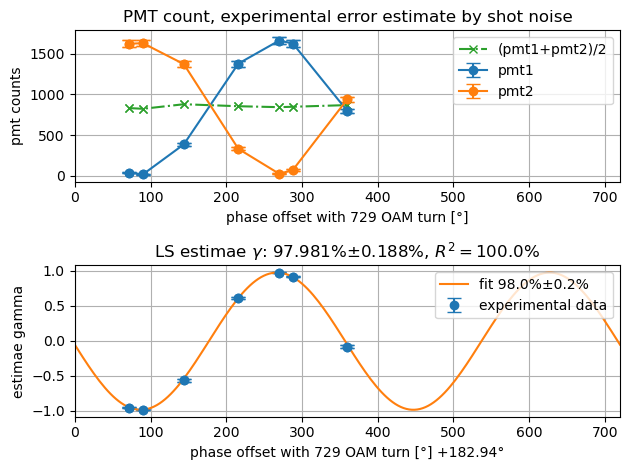

In [3]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
monitor_df=res_data[res_data['state']=='monitor']
print('-------------origin data-----------------')
param_origin,param_origin_err=estimate_gamma(origin_df,model_func=model_func_count_offset)
plt.savefig('gamma_fit.jpeg', dpi=300)
plt.show()
# print('-------------Ref data-----------------')
# param_monitor,param_monitor_err=estimate_gamma(monitor_df,model_func=model_func_sin)
# plt.savefig('gamma_fit_ref.jpeg', dpi=300)
# plt.show()

In [ ]:
best_phi_list=np.array([90,180,270,360,450,540,630,720])+param_origin[1]/np.pi*180//90*90
best_turn_list=(best_phi_list-(param_origin[1]/np.pi*180))/360/2
phase_array=np.linspace(0,360*2,500)
turn_array=phase_array/360/2
origin_fit=model_func_count_offset(phase_array,*param_origin)
best_phase_list=best_turn_list*2*360

fig = px.scatter(origin_df, x='phase', y='gamma',error_y='gamma_err',hover_data='turn',title='origin data, estimate gamma : {:.3%}'.format(np.abs(param_origin[0])))
fig.add_scatter(x=phase_array, y=origin_fit, mode='lines', name='Cos Fit',hovertext=['turn={:.3}'.format(i) for i in turn_array],hovertemplate='gamma=%{y:.3f}<br>%{hovertext}')
fig.add_scatter(x=best_phase_list,y=model_func_count_offset(best_phase_list,*param_origin),mode='markers',name='best phi',hovertext=['turn={:.3}'.format(i) for i in best_turn_list],hovertemplate='gamma=%{y:.3f}<br>%{hovertext}')
fig.show()

ValueError: Value of 'hover_data_0' is not the name of a column in 'data_frame'. Expected one of ['turn', 'state', 'start(ps)', 'end(ps)', 'pmt1', 'pmt2', 'g', 'phase', 'gamma', 'gamma_err'] but received: t